In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from GonumMatrixIO import GonumIO
from tqdm import tqdm
from keras.datasets import mnist
import os

import covariantPrototypeLib
import hmcalisterHopfieldUtils
from covariantPrototypeLib import StateThresholdProbe
from typing import List

In [38]:
MNIST_IMAGE_SHAPE = (28, 28)

def flattenImageArray(X):
    return X.reshape(X.shape[0], -1)

def plotImagesInSubplots(imageArray):
    fig, axes = plt.subplots(4,4)
    for im, ax in zip(imageArray, np.ravel(axes)):
        ax: plt.Axes 
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im)
    fig.tight_layout()
    plt.show()

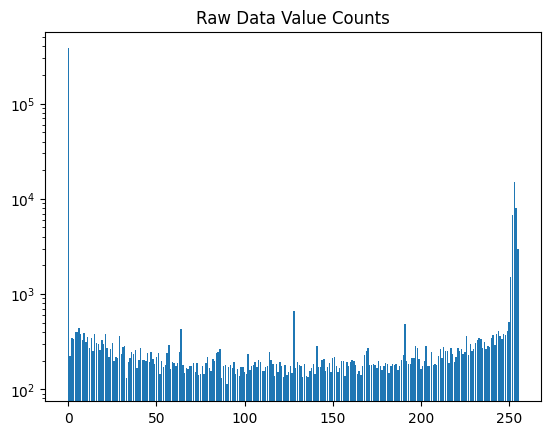

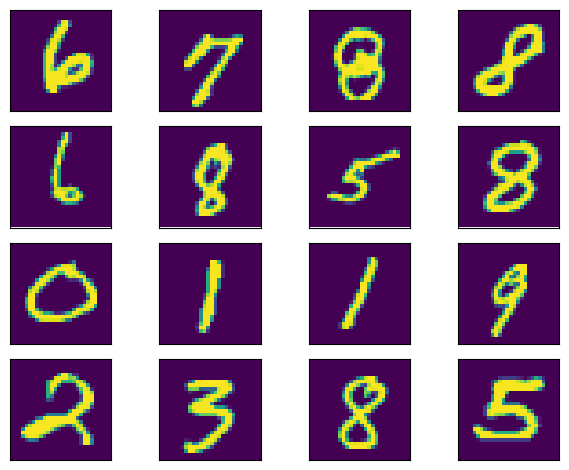

In [39]:
(RAW_X, Y), (_, _) = mnist.load_data()
p = np.random.permutation(len(RAW_X))
RAW_X = RAW_X[p]
Y = Y[p]
RAW_X = RAW_X.astype(int)

SUBSET_FRACTION = 0.01
subsetLimit = int(RAW_X.shape[0] * SUBSET_FRACTION)
ORIG_X = RAW_X[:subsetLimit]
Y = Y[:subsetLimit]

uniqueValues, uniqueCounts = np.unique(ORIG_X, return_counts=True)
plt.bar(uniqueValues, uniqueCounts)
plt.yscale("log")
plt.title("Raw Data Value Counts")
plt.show()

plotImagesInSubplots(ORIG_X)

# RAW MNIST

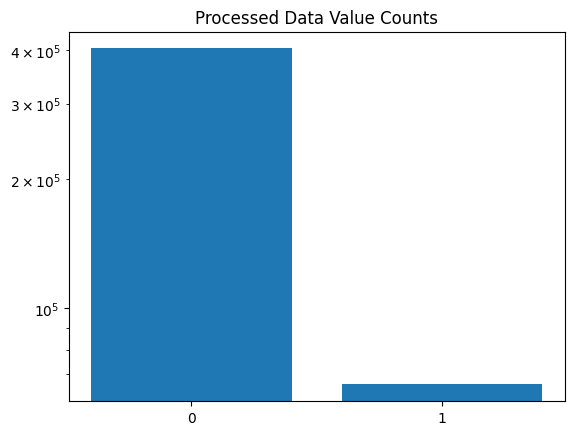

In [23]:
IMAGE_THRESHOLD = 100
RAW_IMAGE_X = hmcalisterHopfieldUtils.hopfield.binaryHeaviside(ORIG_X - IMAGE_THRESHOLD)
RAW_IMAGE_X = flattenImageArray(RAW_IMAGE_X)

uniqueValues, uniqueCounts = np.unique(RAW_IMAGE_X, return_counts=True)
plt.bar(uniqueValues, uniqueCounts)
plt.xticks([0,1], [0,1])
plt.yscale("log")
plt.title("Processed Data Value Counts")
plt.show()

In [11]:
GonumIO.saveMatrix(RAW_IMAGE_X, "data/states.bin")

(600, 784)

In [12]:
statesdf = pd.read_parquet("data/states.pq")
relaxationResultsdf = pd.read_parquet("data/relaxationResults.pq")

stateResults: List[StateThresholdProbe] = []
stateIndices = np.sort(np.unique(statesdf["StateIndex"]))
for stateIndex in stateIndices:
    state = statesdf[statesdf["StateIndex"] == stateIndex].iloc[0]["State"]
    stateRelaxationResults = relaxationResultsdf[relaxationResultsdf["StateIndex"] == stateIndex].sort_values("ThresholdValue")
    thresholdSchedule = np.array(stateRelaxationResults["ThresholdValue"])
    thresholdProbingResults = np.vstack(stateRelaxationResults["RelaxationResult"])
    stateResults.append(StateThresholdProbe(state, thresholdSchedule, thresholdProbingResults))

states = list(statesdf["State"])

# PCA MNIST

TODO: Find a way to implement Binary PCA

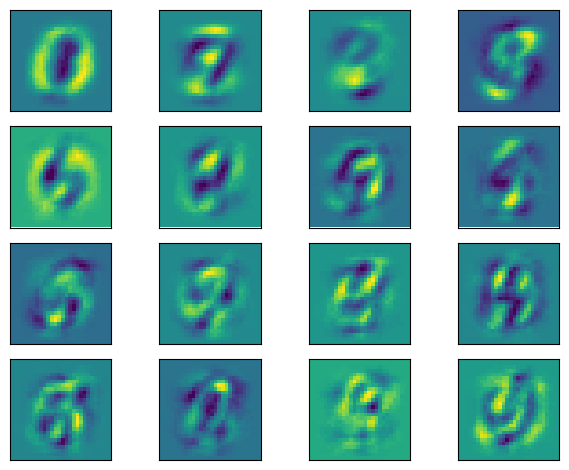

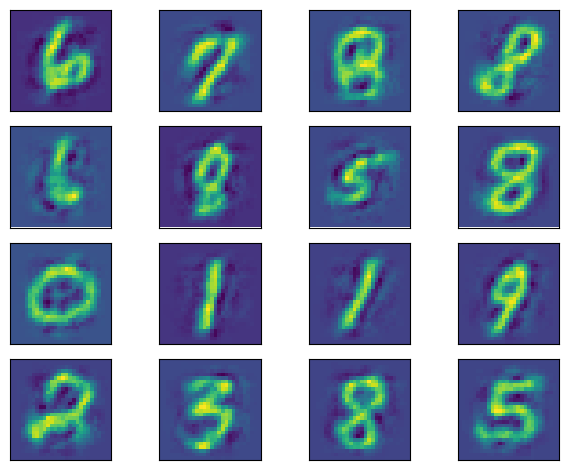

MIN/MAX OF TRANSFORMED X: -5.084762238491084 7.531825163613125
MIN/MAX OF RECREATED IMAGES: -0.6639460851708021 1.503032684835697


In [69]:
from sklearn.decomposition import PCA

IMAGE_THRESHOLD = 100
binaryX = hmcalisterHopfieldUtils.hopfield.binaryHeaviside(ORIG_X - IMAGE_THRESHOLD)

flatX = flattenImageArray(binaryX)
pca = PCA(n_components=32)
pca.fit(flatX)
components = pca.components_.reshape(-1, *MNIST_IMAGE_SHAPE)
plotImagesInSubplots(components)

flatXTransformed = pca.transform(flatX)
recreatedImages = pca.inverse_transform(flatXTransformed).reshape(-1, *MNIST_IMAGE_SHAPE)
plotImagesInSubplots(recreatedImages)
print("MIN/MAX OF TRANSFORMED X:", np.min(flatXTransformed), np.max(flatXTransformed))
print("MIN/MAX OF RECREATED IMAGES:", np.min(recreatedImages), np.max(recreatedImages))

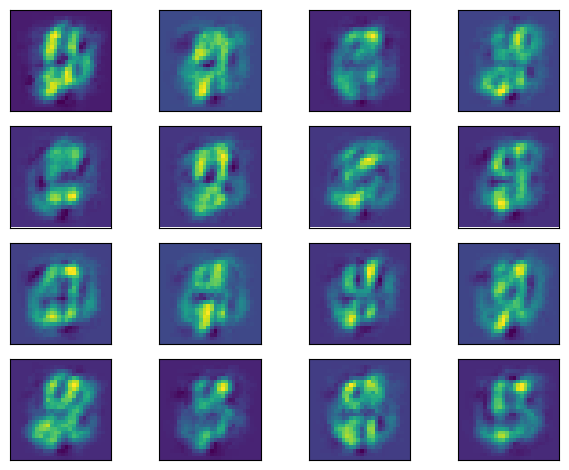

MIN/MAX OF TRANSFORMED X: 0 1
MIN/MAX OF RECREATED IMAGES: -0.43387758355077666 1.3959850608859803


In [70]:
flatXTransformed = pca.transform(flatX)
flatXTransformed = hmcalisterHopfieldUtils.hopfield.binaryHeaviside(flatXTransformed)
recreatedImages = pca.inverse_transform(flatXTransformed).reshape(-1, *MNIST_IMAGE_SHAPE)
plotImagesInSubplots(recreatedImages)
print("MIN/MAX OF TRANSFORMED X:", np.min(flatXTransformed), np.max(flatXTransformed))
print("MIN/MAX OF RECREATED IMAGES:", np.min(recreatedImages), np.max(recreatedImages))

# AUTOENCODER MNIST